In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-asnwer-text-dataset-2/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BULDING DATASET

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=192, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [14]:
def combined_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get KMeans samples
        kmeans_indices = get_kmeans_samples(model, dataloader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")
        
        # Get Least Confidence samples
        lc_indices = get_least_confidence_samples(model, dataloader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(kmeans_indices).union(set(lc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    '1-FR': [y_train[i][0] for i in temp],
                    '2-GI': [y_train[i][1] for i in temp],
                    '3-PI': [y_train[i][2] for i in temp],
                    '4-DM': [y_train[i][3] for i in temp],
                    '5-EDTRB': [y_train[i][4] for i in temp],
                    '6-RE': [y_train[i][5] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_kmeans_samples(model, dataloader, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    
    # Cluster the data based on its embeddings
    kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
        
        if cluster_indices.size == 0:
            # Skip clusters with no members
            continue
        
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
        
        # Determine the local threshold (90th percentile of distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        
        # Get indices of points with distances greater than or equal to threshold
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)
    
    # Randomly shuffle and select required number of samples
    collected_indices = np.array(list(collected_indices))
    
    # Return only the requested number of samples
    return collected_indices[:n_samples]

def get_least_confidence_samples(model, dataloader, device, n_samples):
    model.eval()
    uncertainties = []
    
    # Calculate uncertainties
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        
        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = 'dat-lc-kmeans'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    # model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2')
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6016, Accuracy: 0.8285, F1 Micro: 0.8825, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4016, Accuracy: 0.9503, F1 Micro: 0.9625, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3298, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2995, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2396

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.515, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.309, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2312, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2136, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2192, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1994, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2086, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1595, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4351, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2022, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9535, F1 Micro: 0.9646, F1 Macro: 0.6481
Epoch 9/10, Train Loss: 0.0903, Accuracy: 0.9535, F1 Micro: 0.9646, F1 Macro: 0.6481
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1529, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 8/10, Train Loss: 0.1309, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1109, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1998, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0898, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 10/10, Train Loss: 0.0523, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.093, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7375
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3441, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7418
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0499, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3441, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1994, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3134, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7945
Epoch 10/10, Train Loss: 0.0424, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.316, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1988, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.727
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.699
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.718
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.296, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7381
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8093
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9535, F1 Micro: 0.9651, F1 Macro: 0.7233
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7242
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0434, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2947, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1966, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7628
Epoch 5/10, Train Loss: 0.091, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7451
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7976
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.8035
Epoch 10/10, Train Loss: 0.0352, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2806, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1363, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1117, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8286
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7628
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7628
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7426
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7939
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7515
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1996, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7416
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7956
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8115
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1219, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7299
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8038
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7274
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8317
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8206
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0948, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0662, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7486
Epoch 7/10, Train Loss: 0.0474, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7231
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7541
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2539, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1575, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8187
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7858
Epoch 10/10, Train Loss: 0.0247, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2471, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1324, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.093, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7262
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7253
Epoch 7/10, Train Loss: 0.0539, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0427, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8022
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7914
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0316, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2474, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8194
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8187
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8187
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2459, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1327, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Epoch 5/10, Train Loss: 0.0892, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7241
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7532
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7247
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7358
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7278

 Iteration 390: Accuracy: 0.9663, F1 Micro: 0.9741, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2453, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1387, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1091, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 5/10, Train Loss: 0.0864, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7447
Epoch 6/10, Train Loss: 0.0625, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7187
Epoch 7/10, Train Loss: 0.0399, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.8091
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.803
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8172
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.8162

 Iteration 400: Accura

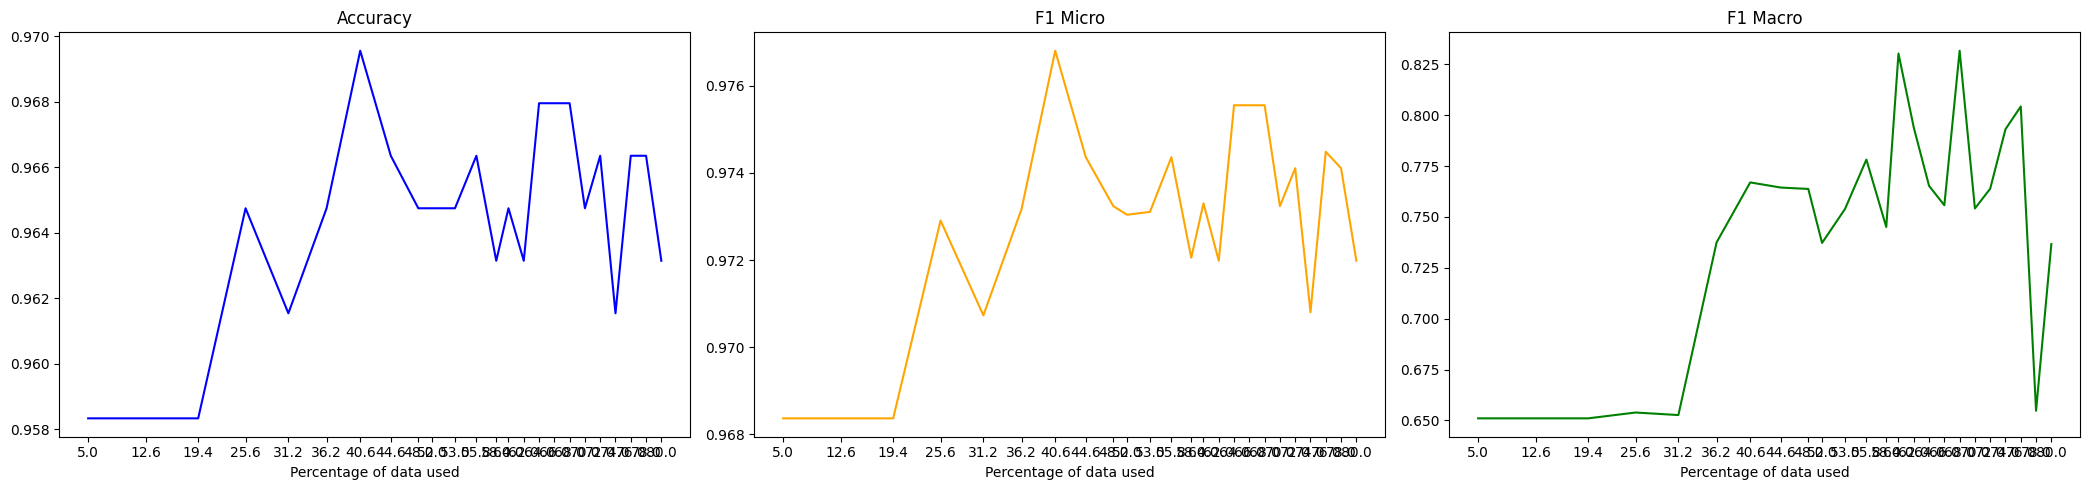

In [17]:
active_learning(seeds[0], 0)